In [1]:
%pylab inline
import pandas as pd

import torch
import torch.nn as nn

from datasets.cmnist import make_joint_distribution
from utils.distribution import DiscreteDistribution, compute_ce, compute_kl
from models.training import train
from models.encoders import DiscreteEncoder

from models.criteria import InformationBottleneckCriterion, IndependenceCriterion, SufficiencyCriterion, SeparationCriterion

Populating the interactive namespace from numpy and matplotlib


# Data distribution

We will use the y-CMNIST data distribution as an example in this notebook, which defines a joint distribution of digits $d$, color $c$, pictures $x$, environments $e$, labels $y$ and selection $t$.
The binary selection variable $t$ indicates if the data is selected for training $t=1$ or not $t=0$.

In [2]:
# Create the joint distribution for y-CMNIST (CMNIST or d-CMNIST are also available)
dist = make_joint_distribution('y-CMNIST')

print('Joint distribution: %s' %dist)

Joint distribution: p(y,e,d,x,c,t)


The joint distribution factorizes as $p(y,e,d,x,c,t) = p(y|d)p(e)p(d)p(c|y,e)p(x|c,d)p(t|e)$.
Train and test distributions are created by conditioning on $t=1$ and $t=0$, respectively.

In [3]:
# Create the training distribution by selecting t=1 and marginalizing d and c
train_dist = dist.condition_on('t',1)

# Create the test distribution by selecting t=0 and marginalizing d, c and e
test_dist = dist.condition_on('t',0)

print('Train distribution: %s' %train_dist)
print('Test distribution: %s' %test_dist)

Train distribution: p(y,e,d,x,c|t=1)
Test distribution: p(y,e,d,x,c|t=0)


We can describe how distant the train and test distributions are by computing $I(xy;t)$, which represents how much information the selection carries about the joint distribution of raw features (pictures $s$) and targets (labels $y$). The distribution shift can be seen as the joint effect of covariate shift $I(t;x)$ and concept shift $I(y;t|x)$:

$$\underbrace{I(xy;t)}_{\text{distribution shift}} = \underbrace{I(x;t)}_{\text{covariate shift}} + \underbrace{I(y;t|x)}_{\text{concept shift}}$$

In [4]:
# Compute the amout of distribution shift I(xy;t)
print('Distribution shift: %f nats' %(dist.compute('I(x,y;t)')))

# Compute the amout of concept shift I(y;t|x)
print('Concept shift: %f nats' %(dist.compute('I(y;t|x)')))

# Compute the amout of concept shift I(x;t)
print('Covariate shift: %f nats' %(dist.compute('I(x;t)')))

Distribution shift: 0.306607 nats
Concept shift: 0.237813 nats
Covariate shift: 0.068793 nats


Note that the selection $t$ does induce concept shift, therefore a maximum likelihood solution must result in positive OOD error.
Given a model $\hat q(y|x)$ that is optimal on the training distribution $p(y|x,t=1)$ we have:
$$ KL(p(y|x,t=0)||\hat q(y|x))\ge I(y;t|x) > 0 $$

In [5]:
# Consider a model q(y|x) that matches the train distribution p(y|x,t=1)
q_y_x = train_dist.conditional('y','x')
print('q(y|x)=%s' % q_y_x)

# Compute the OOD error for q(y|x): KL(p(y|x,t=0)||q(y|x))
ood_error = compute_kl(test_dist, q_y_x)
print('OOD error: %f nats' % ood_error)

q(y|x)=p(y|x,t=1)
OOD error: 1.249681 nats


We visualize train and OOD cross-entropy for models that rely on pictures $x$, color $c$, digit $d$ or prior information.

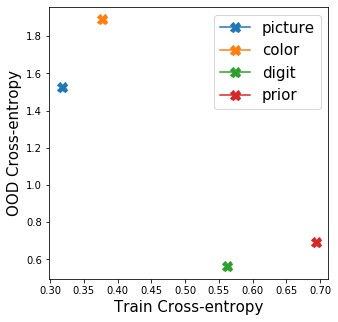

In [6]:
# compute and plot train and OOD cross-entropy for models that use picures 'x', color 'c', digit 'd'
def plot_default():
    f, ax = plt.subplots(1,1,figsize=(5,5))
    for variable, label in [('x','picture'),('c','color'),('d','digit')]:
        train_ce = compute_ce(train_dist, train_dist.conditional('y', variable))
        ood_ce = compute_ce(test_dist, train_dist.conditional('y', variable))
        ax.plot(train_ce, ood_ce, marker='X', markersize=10, label=label)


    # and prior information
    train_ce = compute_ce(train_dist, train_dist.marginal('y'))
    ood_ce = compute_ce(test_dist, train_dist.marginal('y'))
    ax.plot(train_ce, ood_ce, marker='X', markersize=10, label='prior')

    ax.set_xlabel('Train Cross-entropy', fontsize=15)
    ax.set_ylabel('OOD Cross-entropy', fontsize=15);
    
plot_default()
plt.legend(fontsize=15)

Models that rely on digit information effectively minimize the OOD cross-entropy. 

As a next step we will consider models that have only access to pictures $x$, targets $y$ and environments $e$ at training time. Each model is composed of an encoder $q(z|x)$ and classifier $\hat q(y|z)$ that matches the predictive distribution $p(y|z,t=1)$.

The goal is to create a representation $z$ that reduces latent concept drift $I(y;t|z)$, in other words, a representation from which the same classifier works well on both splits $t=1$ and $t=0$.
This can be done by optimizing the encoders according to different criteria.

# Model Training

Here we explore the effect of training a latent representation using the following criteria:
- Information Bottleneck $I(x;z)$
- Independence $I(e;z)$
- Sufficiency $I(e;y|z)$
- Separation $I(e;z|y)$

In particular, here we compare the effect of separation and sufficiency on the y-CMNIST data distribution to underline the shortcomings of representation trained by enforcing $I(e;y|z)$ that are quite common in the recent litterature.

## Separation Criterion

We start by defining a learnable encoder parametrized by a matrix $\bf W$

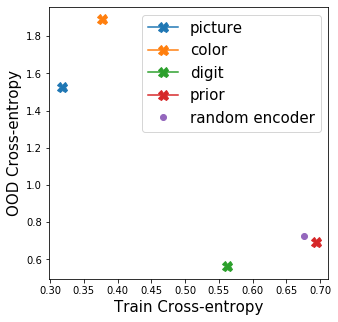

In [7]:
# Create an encoder which maps each 'x' into a latent 'z' which consists of 64 different values
encoder = DiscreteEncoder(z_dim=64)

# Compute the predictive distribution p(y|z,t=1) induced by the encoder
q_y_z = encoder(train_dist).conditional('y','z')

# Compute and visualize the train and ood cross-entropy for the model with random initialization
train_ce = compute_ce(encoder(train_dist),q_y_z).item()
ood_ce = compute_ce(encoder(test_dist),q_y_z).item()

plot_default()
plt.plot(train_ce,ood_ce, 'o', label='random encoder')

plt.legend(fontsize=15)

Since the encoder is initialized randomly, the representation contains little label information, and the corresponding model performs similarly to a model that does not rely on any input information (red cross):
$$p(y|z,t=1)\approx p(y|t=1)$$ 

Next, we train the encoder unsing the separation criterion and a strong regularization $\lambda=10^6$, hoping to enforce the separation constraint $I_{t=1}(e;z|y)=0$, while maximizing the amount of predictive information accessible from $z$ ($I_{t=1}(y;z)$).

The resulting objective is in the form:
$$\min_{q(z|x)} -I_{t=1}(y;z) + \lambda I_{t=1}(e;z|y)$$

We train the encoder until convergence.

In [9]:
# Use the Separation criterion for training. 
# SufficiencyCriterion, SeparationCriterion and InformationBottleneckCriterion are also available
criterion = SeparationCriterion(reg=1e6)

# Train until convergence 
logs = train(encoder, criterion, train_dist.marginal(['x','y','e']), test_dist.marginal(['x','y']), verbose=True)

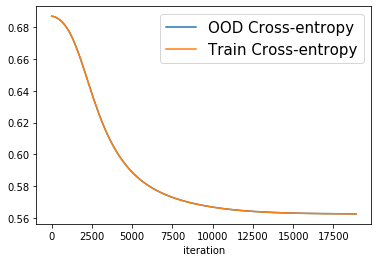

In [10]:
# Visualize train and OOD cross-entropy over the training iterations
logs = pd.DataFrame(logs)
logs.plot(x='iteration')
plt.legend(fontsize=15)

First, we check that the model managed to enforce the separation constraint on the train distribution $p(x,y,e|t=1)$ and on the overall distribution $p(x,y,e)$

In [11]:
# Compute I_{t=1}(e;z|y) on the train distribution
print('I_{t=1}(e;z|y): %f nats' % encoder(train_dist).compute('I(e;z|y)'))

# and on the overall distribution
print('I(e;z|y): %f nats' % encoder(dist).compute('I(e;z|y)'))

I_{t=1}(e;z|y): 0.000000 nats
I(e;z|y): -0.000000 nats


Since the model enforces separation on the overall distribution ($I(e;z|y)=0$) and the selection can be expressed as a function of the environments $t=f(e)$, we know that the latent concept drift $I(y;t|z)$ is upper bounded by the amount of prior shift $I(y;t)$

In [12]:
# Compare latent concept shift and prior shift
print('I(y;t|z) = %f nats <= I(y;t) = %f nats' % (encoder(dist).compute('I(y;t|z)'), dist.compute('I(y;t)')))

I(y;t|z) = 0.000000 nats <= I(y;t) = 0.000000 nats


Since the latent concept shift is zero, we also know that the latent OOD error $KL(p(y|z,t=0)||\hat q(y|z))$ must be zero. This means that all the observed test error must be caused by the predictive information that has been lost during the encoding procedure:
$$\underbrace{KL(p(y|x,t=0)||\hat q(y|z))}_{\text{OOD error}} = \underbrace{I_{t=0}(x;y|z)}_{\text{Test Information loss}} + \underbrace{KL(p(y|z,t=0)||\hat q(y|z))}_{\text{Latent OOD error}}$$

In [13]:
# The classifier q(y|z) matches the training predictive distribution p(y|z, t=1)
q_y_z =  encoder(train_dist).conditional('y','z')

# Compute latent OOD error: KL(p(y|z,t=0)||q(y|z))
print('Lantent OOD error: %f nats' % compute_kl(encoder(test_dist),q_y_z))

# Compute latent OOD error: KL(p(y|z,t=0)||q(y|z))
print('OOD error: %f nats' % compute_kl(encoder(test_dist), q_y_z, 'x'))

# Compute the amount of test information lost on the test distribution: I_{t=0}(x;y|z)
print('Test Information loss: %f nats' % encoder(test_dist).compute('I(x;y|z)'))


Lantent OOD error: -0.000000 nats
OOD error: 0.285917 nats
Test Information loss: 0.285917 nats


We visualize the train and OOD cross-entropy of the trained model on the previous picture

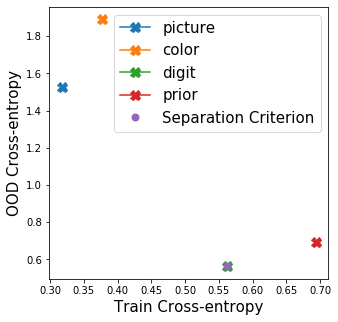

In [14]:
# Compute and visualize the train and ood cross-entropy for the model after training
q_y_z = encoder(train_dist).conditional('y','z')

sep_train_ce = compute_ce(encoder(train_dist),q_y_z).item()
sep_ood_ce = compute_ce(encoder(test_dist),q_y_z).item()

plot_default()
plt.plot(sep_train_ce, sep_ood_ce, 'o', markersize=7, label='Separation Criterion')

plt.legend(fontsize=15);

The representation $z$ manages to successfully reduce the OOD cross-entropy. Train and OOD cross-entropy are equivalent to the ones observed for an encoder that extracts only digit information.

## Sufficiency Criterion

We repeat the same procedure by applying the separation criterion instead:
$$ \min_{q(z|x)} -I(y;z) + \lambda I(e;y|z)$$

In [15]:
# Re-initialize the encoder 
encoder = DiscreteEncoder(z_dim=64)

# Define the SufficiencyCriterion
criterion = SufficiencyCriterion(reg=1e6)

# Train until convergence 
logs = train(encoder, criterion, train_dist.marginal(['x','y','e']), test_dist.marginal(['x','y']), verbose=False)

Once again, we check if the model manages to enforce the sufficiency constraint $I(e;y|z)=0$

In [16]:
# Compute I_{t=1}(e;z|y) on the train distribution
print('I_{t=1}(e;y|z): %f nats' % encoder(train_dist).compute('I(e;y|z)'))

# and on the overall distribution
print('I(e;y|z): %f nats' % encoder(dist).compute('I(e;y|z)'))

I_{t=1}(e;y|z): 0.034149 nats
I(e;y|z): 0.133128 nats


We notice that the encoder does not manage to enforce $I_{t=1}(e;y|z)=0$ on the selection $t=1$. This is because in the y-CMNIST graphical model, there is no variable (or group of variables) that is able to make label and environment conditionally independent

In [17]:
# Compute sufficiency for picture, color and digit information
for variable in ['x','c','d']:
    print('I_{t=1}(e;y|z=%s): %f nats' % (variable, train_dist.compute('I(e;y|%s)'% variable)))

I_{t=1}(e;y|z=x): 0.037057 nats
I_{t=1}(e;y|z=c): 0.044354 nats
I_{t=1}(e;y|z=d): 0.048106 nats


Since the sufficiency constraint is not enforced, we have no guarantees on the latent concept shift $I(y;t|d)$, and the latent OOD error can be strictly positive

In [18]:
# The classifier q(y|z) matches the training predictive distribution p(y|z, t=1)
q_y_z =  encoder(train_dist).conditional('y','z')

# Compute latent concept shift I(y;t|z)
print('Lantent concept shift: %f nats' % encoder(dist).compute('I(y;t|z)'))

# Compute latent OOD error: KL(p(y|z,t=0)||q(y|z))
print('Lantent OOD error: %f nats' % compute_kl(encoder(test_dist),q_y_z))

# Compute latent OOD error: KL(p(y|z,t=0)||q(y|z))
print('OOD error: %f nats' % compute_kl(encoder(test_dist), q_y_z, 'x'))

# Compute the amount of test information lost on the test distribution: I_{t=0}(x;y|z)
print('Test Information loss: %f nats' % encoder(test_dist).compute('I(x;y|z)'))


Lantent concept shift: 0.110362 nats
Lantent OOD error: 0.506386 nats
OOD error: 0.888253 nats
Test Information loss: 0.381867 nats


We visualize train and OOD cross-entropy together with the previously computed quantities

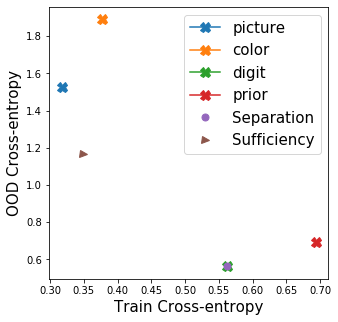

In [19]:
# Compute and visualize the train and ood cross-entropy for the model after training
q_y_z = encoder(train_dist).conditional('y','z')

suff_train_ce = compute_ce(encoder(train_dist),q_y_z).item()
suff_ood_ce = compute_ce(encoder(test_dist),q_y_z).item()

plot_default()
plt.plot(sep_train_ce, sep_ood_ce, 'o', markersize=7, label='Separation')
plt.plot(suff_train_ce, suff_ood_ce, '>', markersize=7, label='Sufficiency')


plt.legend(fontsize=15);

We can see that the encoder trained with the sufficiency criterion is not able to minimize the OOD error as effectively as the model trained with the separation criterion.

On d-CMNIST distribution instead, we can observe the opposite: sufficiency minimizes the OOD error while separation does not.

Both criteria work equally well on the original CMNIST distribution